### Import library

In [1]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from math import *
from numpy.linalg import inv

### Gravity constant by time

Approximating the function of gravity constant by time while airplane manueuver w/ sine function (Take off & Landing)



$$
G(t) = Asin(Bt+C)+D
$$

In [2]:
def objective(params):
    A, B, C, D = params
    # Define the sine function
    f = lambda t: A * np.sin(B * t + C) + D
    # Errors at each given point
    error1 = f(20) - 9.8
    error2 = f(30) - (1.6 * 9.8)
    error3 = f(40) - 9.8
    error4 = f(42) - 0.0
    # Sum of squared errors
    return 10*error1**2 + error2**2 + error3**2 + 15*error4**2


def fitted_sine_function(A, B ,C ,D, t):
    return A * np.sin(B * t + C) + D

In [3]:
initial_guess = [10, 0.1, 0, 9.8]

In [4]:
result = minimize(objective, initial_guess)
param = result.x

A, B, C, D = param

time_lift = np.linspace(20, 42, 1000)
time_drop = np.linspace(78, 100, 1000)

# Calculate the sine values for the time range
sin_drop = fitted_sine_function(A, B, C, D, 120-time_drop)
sin_lift = fitted_sine_function(A, B, C, D, time_lift)

hyperG = np.zeros(4000)
hyperG[: len(sin_lift)] = sin_lift  # First 22 entries from sin_drop
hyperG[len(sin_lift) + int(36/22*1000): len(sin_lift) + int(36/22*1000)+len(sin_drop)] = sin_drop  # Last part of the array from sin_lift
hyperG[len(sin_lift) + int(36/22*1000)+len(sin_drop):] = 9.8

### Pendulum simulation parameter

In [5]:
g = 9.8 # 9.8 m/s**2
ll = 13.5 # length 13.5 meters
c = 0.1 # damping tern due to friction
F0 = .65 # driving amplitude by wheel motor
omega = sqrt(g/ll)

t = 0.0
delta_t = 0.02

#init condition
theta0 = 0.0*pi/180.
thetadot0 = 0.0

In [6]:
y = np.array([thetadot0, theta0])

L = np.array([[ll, 0.0],
              [0.0, 1.0]])

F = np.array([0.0, 0.0])

inv_L = inv(L)
dF = 0

### Solving pendulum's equation of motion via Runge-Kutta method


##### Equation of Motion
**Lift time:** the time when the pendulum reaches 60 degrees relative to its equilibrium position due to periodic external force.

In my simulation the lift time is 39.44s.

1. **0 ~ Lift time: periodic external force,** $g = 9.8$

   $
   \ddot{\theta} + c\dot{\theta} + g(t)\sin{\theta} = F_0 \cos{(\omega t)}
   $

2. **Lift time ~ Lift time + 22s: No external force,** $g(t) = A \sin{(Bt + C)} + D$

   (A, B, C, D are fitting variables for hyper gravity when departure)

   $
   \ddot{\theta} + c\dot{\theta} + g(t)\sin{\theta} = 0
   $

3. **Lift time + 22s ~ Lift time + 58s: no external force,** $g=0$

   $
   \ddot{\theta} + c\dot{\theta} = 0
   $

4. **Lift time + 58s ~ Lift + 80s: no external force,** $g'(t) = A' \sin{(B't + C')} + D'$

   (A', B', C', D' are fitting variables for hyper gravity when arrival. I assumed the hyper gravity for departure and arrival to be mirror symmetry.)

   $
   \ddot{\theta} + c\dot{\theta} + g(t)\sin{\theta} = 0
   $

5. **Lift + 80s ~: no external force,** $g = 9.8$

   $
   \ddot{\theta} + c\dot{\theta} + g(t)\sin{\theta} = 0
   $


In [7]:
def G(t, y, df):
    F[0] = df-g*sin(y[1]) - c*y[0]
    F[1] = y[0]
    return inv_L.dot(F)

def RK4(t, y, delta_t, df):
    k1 = G(t, y, df)
    k2 = G(t+0.5*delta_t, y+0.5*delta_t*k1, df)
    k3 = G(t+0.5*delta_t, y+0.5*delta_t*k2, df)
    k4 = G(t+1.0*delta_t, y+1.0*delta_t*k3, df)
    return k1/6.0 + 2.0*k2/6.0 + 2.0*k3/6.0 + k4/6.0

In [8]:
thetadot = []
theta = []
FF = []
GG = []

In [9]:
count = 0
lift_start = False
lift_time = 0.0
hypertime = 0

#### Solve the equation of motion

In [10]:
while True:
    t += delta_t
    count += 1 
    
    if lift_start == False:
        dF=F0*np.cos(omega*t)

    if (pi/3 - 0.01) < abs(y[1]) < (pi/3 + 0.01) and -0.01 < abs(y[0]) < 0.01 and lift_start==False:
        lift_time = t
        lift_start = True
        dF = 0
        print(f"Lift starts at t={lift_time:.2f} seconds")
        
        
    if lift_start:
        if hypertime < len(hyperG):
            g = hyperG[hypertime]
            hypertime += 1  
        else:
            g = 9.8
            
    if lift_time+120<=t:
        break
        
    y = y + delta_t * RK4(t, y, delta_t, dF)
    theta.append(y[1])
    thetadot.append(y[0])
    FF.append(dF)
    GG.append(g)

Lift starts at t=39.44 seconds


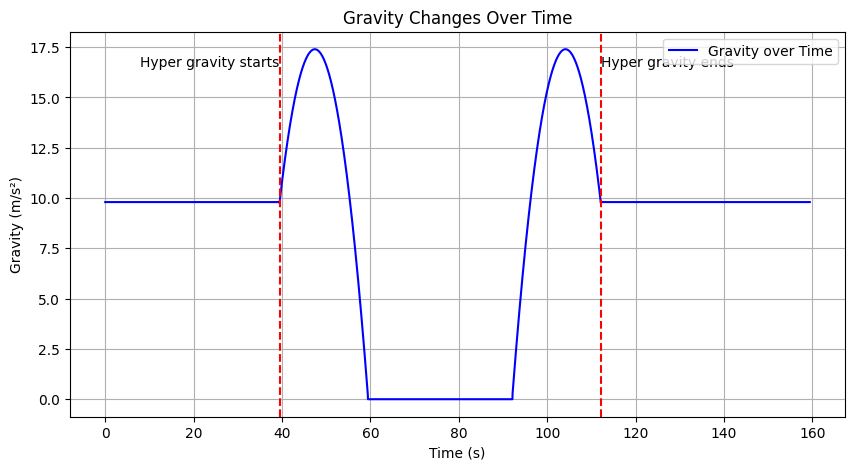

In [11]:
time = np.linspace(0, count * delta_t, count-1)
plt.figure(figsize=(10, 5))
plt.grid(True)
plt.plot(time, GG, 'b', label="Gravity over Time")

# Mark where lift starts
plt.axvline(x=lift_time, color='r', linestyle='--')
plt.text(lift_time, max(GG) * 0.95, 'Hyper gravity starts', horizontalalignment='right', color='black')

# Calculate lift end time based on the duration hyperG influences the gravity
lift_end_time = + lift_time + (len(sin_lift)+ int(36/22*1000)+len(sin_drop)) * delta_t
plt.axvline(x=lift_end_time, color='r', linestyle='--')
plt.text(lift_end_time, max(GG) * 0.95, 'Hyper gravity ends', horizontalalignment='left', color='black')

plt.xlabel("Time (s)")
plt.ylabel("Gravity (m/s²)")
plt.title("Gravity Changes Over Time")
plt.legend()
plt.show()

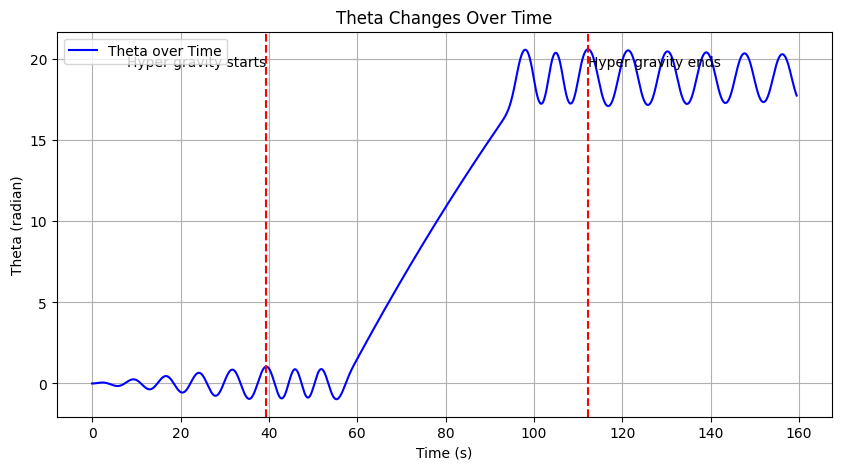

In [12]:
time = np.linspace(0, count * delta_t, count-1)
plt.figure(figsize=(10, 5))
plt.grid(True)
plt.plot(time, theta, 'b', label="Theta over Time")

# Mark where lift starts
plt.axvline(x=lift_time, color='r', linestyle='--')
plt.text(lift_time, max(theta) * 0.95, 'Hyper gravity starts', horizontalalignment='right', color='black')

lift_end_time = + lift_time + (len(sin_lift)+ int(36/22*1000)+len(sin_drop)) * delta_t
plt.axvline(x=lift_end_time, color='r', linestyle='--')
plt.text(lift_end_time, max(theta) * 0.95, 'Hyper gravity ends', horizontalalignment='left', color='black')

plt.xlabel("Time (s)")
plt.ylabel("Theta (radian)")
plt.title("Theta Changes Over Time")
plt.legend()
plt.show()

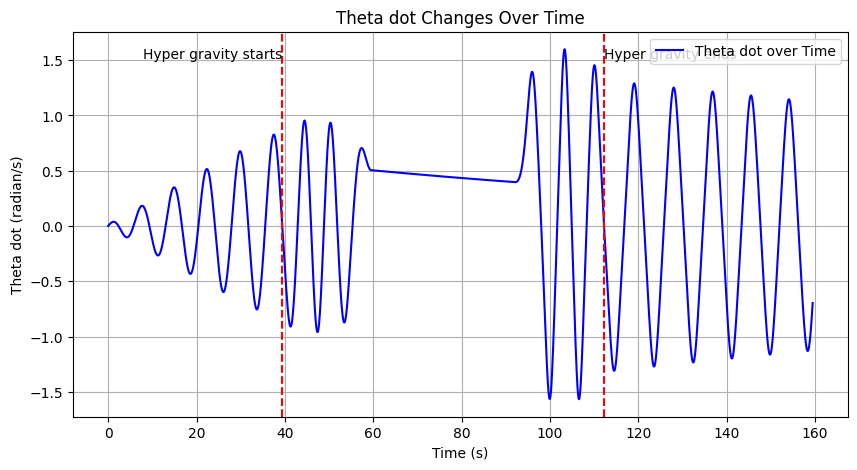

In [13]:
time = np.linspace(0, count * delta_t, count-1)
plt.figure(figsize=(10, 5))
plt.grid(True)
plt.plot(time, thetadot, 'b', label="Theta dot over Time")

# Mark where lift starts
plt.axvline(x=lift_time, color='r', linestyle='--')
plt.text(lift_time, max(thetadot) * 0.95, 'Hyper gravity starts', horizontalalignment='right', color='black')

lift_end_time = + lift_time + (len(sin_lift)+ int(36/22*1000)+len(sin_drop)) * delta_t
plt.axvline(x=lift_end_time, color='r', linestyle='--')
plt.text(lift_end_time, max(thetadot) * 0.95, 'Hyper gravity ends', horizontalalignment='left', color='black')

plt.xlabel("Time (s)")
plt.ylabel("Theta dot (radian/s)")
plt.title("Theta dot Changes Over Time")
plt.legend()
plt.show()

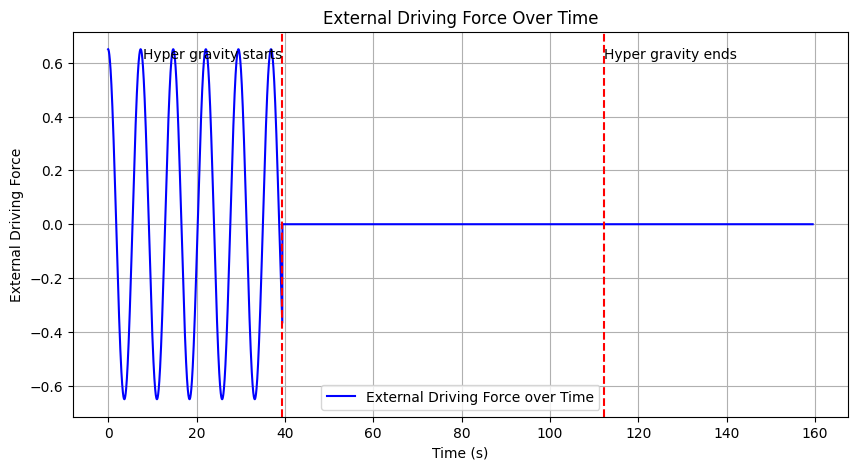

In [14]:
time = np.linspace(0, count * delta_t, count-1)
plt.figure(figsize=(10, 5))
plt.grid(True)
plt.plot(time, FF, 'b', label="External Driving Force over Time")

# Mark where lift starts
plt.axvline(x=lift_time, color='r', linestyle='--')
plt.text(lift_time, max(FF) * 0.95, 'Hyper gravity starts', horizontalalignment='right', color='black')

lift_end_time = + lift_time + (len(sin_lift)+ int(36/22*1000)+len(sin_drop)) * delta_t
plt.axvline(x=lift_end_time, color='r', linestyle='--')
plt.text(lift_end_time, max(FF) * 0.95, 'Hyper gravity ends', horizontalalignment='left', color='black')

plt.xlabel("Time (s)")
plt.ylabel("External Driving Force")
plt.title("External Driving Force Over Time")
plt.legend()
plt.show()